In [1]:
import os
import sys

#add parent path to system path
par_path = os.path.abspath(os.path.join('..'))
if par_path not in sys.path:
    sys.path.append(par_path)
    
data_path = os.path.join(par_path,'data')

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rd
import scipy.optimize as opt
import time

# <center> Agent-based model </center>

Here, we shall look at the interaction table of the binary agreement model. Two agents are selected, one with a speaker role and the other with a listener role. The speaker selects an opinion from their portfolio, and shares it to the listener. If they both have that opinion, they both end up having that opinion exclusively. Otherwise, the opinion is added to the portfolio of the listener.

\begin{equation}
\begin{array}{cc}
\textrm{Before interaction} & \textrm{After interaction} \\
A \overset{A}{\to} A & A - A \\
A \overset{A}{\to} B & A - AB \\
A \overset{A}{\to} AB & A - A \\
B \overset{B}{\to} A & B - AB \\
B \overset{B}{\to} B & B - B \\
B \overset{B}{\to} AB & B - B \\
AB \overset{A}{\to} A & A - A \\
AB \overset{A}{\to} B & AB - AB \\
AB \overset{A}{\to} AB & A - A \\
AB \overset{B}{\to} A & AB - AB \\
AB \overset{B}{\to} B & B - B \\
AB \overset{B}{\to} AB & B - B
\end{array}
\end{equation}

There is a third type of agent - the committed agent. They act like agents with opinion $A$, but do not add opinion $B$ into their portfolio if the speaker shares such an opinion.

In the following code, we shall assume a complete graph.

In [107]:
def exchange(pop, tot):
    """
    Assumes that pop = [B,AB,A,AA] (pop must be numpy array) and tot = sum(pop)
    
    Two integers a drawn from [0,tot-1], representing the speaker and listener.
    The corresponding transformation of the populations are effected.
    """
    
    speaker,listener = rd.randint(tot,size=2)
    
    #get types
    agents = ['B','AB','A','AA']
    subtotal = 0
    for i in range(4):
        if pop[i] > 0:
            subtotal += pop[i]
            if speaker < subtotal:
                speakertype = agents[i]
                break
    subtotal = 0
    for i in range(4):
        if pop[i] > 0:
            subtotal += pop[i]
            if listener < subtotal:
                listenertype = agents[i]
                break
    if speakertype == listenertype:
        if speakertype != 'AB' or pop[1] < 2:
            return pop

    if speakertype == 'B':
        if listenertype == 'AB':
            return pop + [1,-1,0,0]
        if listenertype == 'A':
            return pop + [0,1,-1,0]
        return pop

    if speakertype == 'AB':
        if listenertype == 'B':
            if rd.randint(2): # AB opinion is A
                return pop + [-1,1,0,0]
            else: # AB opinion is B
                return pop + [1,-1,0,0]
        if listenertype == 'AB':
            if rd.randint(2): #AB opinion is A
                return pop + [0,-2,2,0]
            else: #AB opinion is B
                return pop + [2,-2,0,0]
        if listenertype == 'A':
            if rd.randint(2): #AB opinion is A
                return pop + [0,-1,1,0]
            else: # AB opinion is B
                return pop + [0,1,-1,0]
        if listenertype == 'AA':
            if rd.randint(2): #AB opinion is A
                return pop + [0,-1,1,0]
        return pop
    
    ## all that is left is A or AA
    if listenertype == 'B':
        return pop + [-1,1,0,0]
    if listenertype == 'AB':
        return pop + [0,-1,1,0]
    return pop

Let's test the code with a sample calculation near a critical point

In [120]:
tot = 1_000
p = 0.090
AA = int(p*tot)
pop = np.array([tot - AA,0,0,AA])   

Bsum = 0
B_hist = [pop[0]/tot]
Bsum += B_hist[-1]
Bave_hist = [Bsum]

T = 1_000_000
for k in range(T):
    pop=exchange(pop,tot)
    B_hist.append(pop[0]/tot)
    Bsum += B_hist[-1]
    Bave_hist.append(Bsum/(k+2))

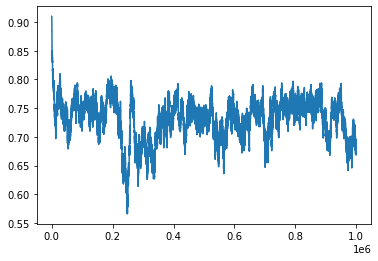

Average value of n_B is 0.7306800973199141


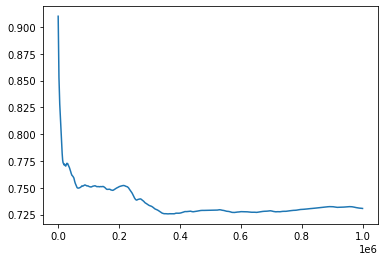

In [121]:
plt.plot(B_hist)
plt.show()
plt.plot(Bave_hist)
print(f'Average value of n_B is {sum(B_hist)/len(B_hist)}')

In [66]:
tot = 1_000
p = 0.100
AA = int(p*tot)
pop = np.array([tot - AA,0,0,AA])   

Bsum = 0
B_hist = [pop[0]/tot]
Bsum += B_hist[-1]
Bave_hist = [Bsum]

T = 1_000_000
for k in range(T):
    pop=exchange(pop,tot)
    B_hist.append(pop[0]/tot)
    Bsum += B_hist[-1]
    Bave_hist.append(Bsum/(k+2))

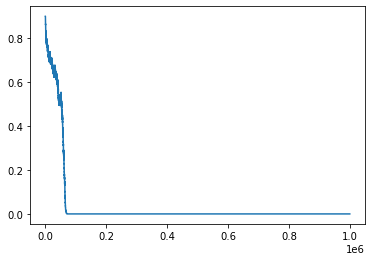

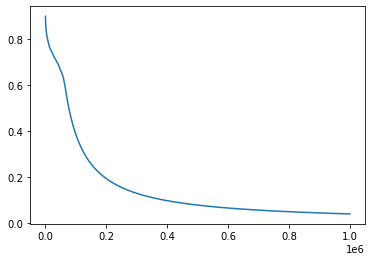

In [67]:
plt.plot(B_hist)
plt.show()
plt.plot(Bave_hist)

# <center> Calculating the stable fixed point </center>

In the infinite network size limit and for complete graphs, the evolution of the probability densities $n_A$ and $n_B$ for agents $A$ and $B$ respectively is given by
\begin{eqnarray}
\dfrac{dn_A}{dt} &=& - n_A n_B + n_{AB}^2 + n_{AB} n_A + \dfrac{3}{2} p n_{AB} \\
\dfrac{dn_B}{dt} &=& - n_A n_B + n_{AB}^2 + n_{AB} n_B - p n_B
\end{eqnarray}
where $n_{AB} = 1 - p - n_A - n_B$ and $p$ is the number density of committed agents.

The fixed points of this dynamical system is given by stationary points,
\begin{equation}
\dfrac{dn_A}{dt} = 0, \qquad \dfrac{dn_B}{dt} = 0
\end{equation}

There are at most three relevant roots: when all opinions agree with the committed minority, and a pair of stable and unstable fixed points. It is this stable fixed point which we wish to calculate.

The paper has given an approximation for the root,
\begin{equation}
n_B = t^2 \dfrac{4 - p}{2}, \qquad n_A = \dfrac{(4 - n_B - p)^2 - 9 p^2}{8p + 16}
\end{equation}
where
\begin{equation}
t = \dfrac{8}{9\sqrt{3}} + \dfrac{r}{6} + \sqrt{\dfrac{17}{81} - \dfrac{8r}{9\sqrt{3}} - \dfrac{r^2}{12}}
\end{equation}
and
\begin{equation}
r = \dfrac{1 + p/2}{(2 - p/2)^{3/2}}.
\end{equation}
We may use this expressions as a starting point for a secant method to find the stable fixed point.

The stable fixed point exists so long as
\begin{equation}
p < p_c, \qquad p_c = \dfrac{5}{2} - \dfrac{3}{2} \left( \sqrt[3]{5 + \sqrt{24}} - 1 \right)^2 - \dfrac{3}{2} \left( \sqrt[3]{5 - \sqrt{24}} - 1 \right)^2 
\end{equation}

In [71]:
def get_stable_fp(p):
    """
    Calculates the stable fixed point (n_A, n_B).
    
    If the value of p is greater than p_c, then it returns
    (None, None)
    """
    
    def f(pop):
        n_AB = 1 - p - pop[0] - pop[1]
        
        dn_Adt = -pop[0]*pop[1] + n_AB**2 + n_AB*pop[0] + 3/2*p * n_AB
        dn_Bdt = -pop[0]*pop[1] + n_AB**2 + n_AB*pop[1] - p * pop[1]
        
        return [dn_Adt,dn_Bdt]
        
    
    if p >= 5/2 - 3/2 * (np.cbrt(5 + np.sqrt(24)) - 1)**2 - 3/2 * (np.cbrt(5 - np.sqrt(24)) - 1)**2:
        return (None,None)
    
    r = (1+p/2)/(np.sqrt(2 - p/2)**3)
    t = 8/(9*np.sqrt(3)) + r/6 + np.sqrt(17/81 - 8*r/(9*np.sqrt(3)) - r**2/12)
    n_B = t**2 * (4-p)/2
    n_A = ((4 - 4*n_B - p)**2 - 9*p**2)/(8*p+16)
    
    init = [n_A,n_B]
    
    sol = opt.root(f, init)
    return sol.x

Let us compare the approximation with the numerically determined answer.

In [74]:
p = 0.09
r = (1 + p/2)/(np.sqrt(2-p/2)**3)
t = 8/(9*np.sqrt(3)) + r/6 + np.sqrt(17/81 - 8*r/(9*np.sqrt(3)) - r**2/12)

print(f'Approximation: {t**2 * (4-p)/2}, Numerical: {get_stable_fp(p)[1]}')

Approximation: 0.7411317383740974, Numerical: 0.7411776008573454


For the unstable fixed point, one only needs to change the sign of one of the terms of $t$

In [75]:
def get_unstable_fp(p):
    """
    Calculates the unstable fixed point (n_A, n_B).
    
    If the value of p is greater than p_c, then it returns
    (None, None)
    """
    
    def f(pop):
        n_AB = 1 - p - pop[0] - pop[1]
        
        dn_Adt = -pop[0]*pop[1] + n_AB**2 + n_AB*pop[0] + 3/2*p * n_AB
        dn_Bdt = -pop[0]*pop[1] + n_AB**2 + n_AB*pop[1] - p * pop[1]
        
        return [dn_Adt,dn_Bdt]
        
    
    if p >= 5/2 - 3/2 * (np.cbrt(5 + np.sqrt(24)) - 1)**2 - 3/2 * (np.cbrt(5 - np.sqrt(24)) - 1)**2:
        return (None,None)
    
    r = (1+p/2)/(np.sqrt(2 - p/2)**3)
    t = 8/(9*np.sqrt(3)) + r/6 - np.sqrt(17/81 - 8*r/(9*np.sqrt(3)) - r**2/12)
    n_B = t**2 * (4-p)/2
    n_A = ((4 - 4*n_B - p)**2 - 9*p**2)/(8*p+16)
    
    init = [n_A,n_B]
    
    sol = opt.root(f, init)
    return sol.x

Let us compare the approximation with the numerically determined answer.

In [76]:
p = 0.09
r = (1 + p/2)/(np.sqrt(2-p/2)**3)
t = 8/(9*np.sqrt(3)) + r/6 - np.sqrt(17/81 - 8*r/(9*np.sqrt(3)) - r**2/12)

print(f'Approximation: {t**2 * (4-p)/2}, Numerical: {get_unstable_fp(p)[1]}')

Approximation: 0.56612408063064, Numerical: 0.5660821600823112


With these, we can do the following now

In [98]:
tot = 10_000
p = 0.095
AA = int(p*tot)
pop = np.array([tot - AA,0,0,AA])   

Bsum = 0
B_hist = [pop[0]/tot]
Bsum += B_hist[-1]
Bave_hist = [Bsum]

T = 10_000_000
for k in range(T):
    pop=exchange(pop,tot)
    B_hist.append(pop[0]/tot)
    Bsum += B_hist[-1]
    Bave_hist.append(Bsum/(k+2))

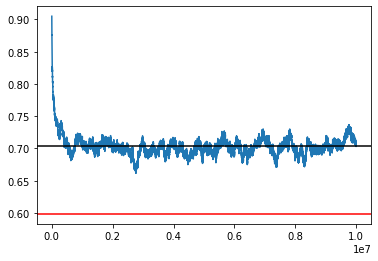

Average value of n_B is 0.7033444182554998


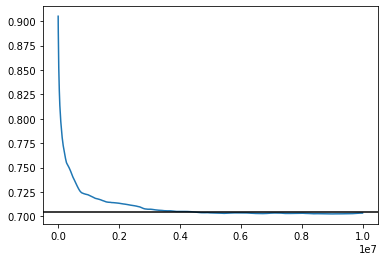

In [99]:
plt.plot(B_hist)
plt.axhline(y = get_stable_fp(p)[1], color = 'k')
plt.axhline(y = get_unstable_fp(p)[1], color = 'r')
plt.show()
plt.plot(Bave_hist)
plt.axhline(y = get_stable_fp(p)[1], color = 'k')
print(f'Average value of n_B is {sum(B_hist)/len(B_hist)}')

# <center> Semi-analytical approach </center>

Consider given by a pair of number, $(n,m)$, which describes a state where there are $n$ agents $A$ and $m$ agents $B$. Given the number of committed agents $c$, this fully describes the population of agents since the undecided population of agents $AB$ is given by $l = N - n - m - c)$

Let $p_{nm}$ be the probability that the population of agents in state $(n,m)$. We may describe the time evolution of this system by considering how neighbouring nodes may populate each state $(n,m)$ and how state $(n,m)$ may populate neighbouring nodes.

This is fully determined by enumerating all the valid transition states and their corresponding probabilities
\begin{equation}
\begin{array}{ccc}
\textrm{Transition} & \textrm{Speaker-Listener pairs} & N^2 \cdot \textrm{Probability} \\
(n,m) \to (n+1,m) & A \overset{A}{\to} AB, AB \overset{A}{\to} A & \dfrac{3}{2} (n+c) \cdot (l) \\
(n,m) \to (n-1,m) & B \overset{B}{\to} A, AB \overset{B}{\to}{A} & n\cdot m + \dfrac{1}{2} n \cdot{l}\\
(n,m) \to (n,m+1) & B \overset{B}{\to} AB, AB \overset{B}{\to} B & \dfrac{3}{2} m \cdot l \\
(n,m) \to (n,m-1) & A \overset{A}{\to} B, AB \overset{A}{\to} B & (n+c)\cdot m + \dfrac{1}{2} m \cdot{l} \\
(n,m) \to (n+2,m) & AB \overset{A}{\to} AB & \dfrac{1}{2}l\cdot(l-1) \\
(n,m) \to (n,m+2) & AB \overset{B}{\to} AB & \dfrac{1}{2} l \cdot (l-1)
\end{array}
\end{equation}

We note the following index transformations,
\begin{equation}
(m \to m + k, l \to l-k), \qquad (n \to n + k, l \to l - k).
\end{equation}

Thus, we get
\begin{equation}
\dfrac{d p_{nm}}{dt} \dfrac{1}{N} = \dfrac{1}{N^2} \left( -p_{mn}\left[ 2( l\cdot (n+m) + n \cdot m) + \dfrac{3}{2} l\cdot c + l \cdot (l-1) + m \cdot c \right] \right)
\end{equation}

In [125]:
a = np.array([[1,2,3,4],[4,5,6,7]])

In [123]:
a[1:] = a[1:]+a[:-1]

In [127]:
a[:,1:]

array([[2, 3, 4],
       [5, 6, 7]])

In [128]:
a[1,0]

4